In [1]:
import base64
from io import BytesIO
import numpy as np
from PIL import Image
import json

import numpy as np
import matplotlib.pyplot as plt

import mediapipe as mp

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from modeling._mano import MANO, Mesh

from metric import oks_metric, oks_over_dataset

In [2]:
!ls data/freihand

test.hw.lineidx     test.linelist.lineidx  train.img.tsv
test.hw.tsv	    test.linelist.tsv	   train.label.lineidx
test.img.lineidx    test.yaml		   train.label.tsv
test.img.tsv	    train.hw.lineidx	   train.linelist.lineidx
test.label.lineidx  train.hw.tsv	   train.linelist.tsv
test.label.tsv	    train.img.lineidx	   train.yaml


# 1. Data

In [3]:
def plot_points(img: np.array, points: np.array):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.scatter(points[:, 0], points[:, 1], c='r')
    plt.show()

In [4]:
class DatasetKeypoints(Dataset):
    def __init__(self, images_path: str, labels_path: str):
        
        self.images_path = images_path
        self.labels_path = labels_path
        
        self.images_data = None
        self.labels_data = None
        self.images_names = None
        
        self._collect_data()
    
    def _get_keypoints(self, img_lbl):
        return json.loads(img_lbl)[0]['hrnet_2d_joints']
    
    def _collect_data(self):
        # read images:
        with open(self.images_path, 'r') as images_file:
            images_raw_data = images_file.readlines()
        images_names, images_b64 = zip(
            *[img_info.split('\t') for img_info in images_raw_data]
        )
        images_data_all = {
            img_n: img_b64
            for img_n, img_b64 in zip(images_names, images_b64)
        }
        # read labels:
        with open(self.labels_path, 'r') as labels_file:
            labels_raw_data = labels_file.readlines()
        images_names, images_labels = zip(
            *[img_lbl.split('\t') for img_lbl in labels_raw_data]
        )
        labels_data_all = {
            img_n: img_l
            for img_n, img_l in zip(images_names, images_labels)
        }
        # select intersecting images:
        intersection_images = (
            set(labels_data_all.keys())
            & set(images_data_all.keys())
        )
        self.images_data = {
            img_n: images_data_all[img_n]
            for img_n in intersection_images
        }
        
        self.labels_data = {
            img_n: self._get_keypoints(labels_data_all[img_n])
            for img_n in intersection_images
        }
        self.images_names = sorted(intersection_images)
        
    def __len__(self):
        return len(self.labels_data.keys())
    
    def _b64_to_array(self, img_b64):
        decoded_img_data = base64.b64decode(img_b64)
        img = Image.open(BytesIO(decoded_img_data))
        return np.array(img)
    
    def __getitem__(self, indx):
        # Returns tuple of numpy instances
        img_n = self.images_names[indx]
        return (
            self._b64_to_array(self.images_data[img_n]),
            np.array(self.labels_data[img_n])
        )

In [5]:
test_ds = DatasetKeypoints(
    './data/freihand/test.img.tsv',
    './data/freihand/test.label.tsv'
)

len(test_ds)

3960

In [21]:
img_array, keypoints_array = test_ds[1]

print(img_array.shape)
print(keypoints_array.shape)

(224, 224, 3)
(21, 2)


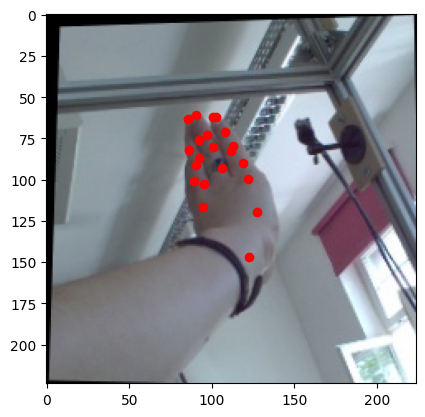

In [22]:
plot_points(img_array, keypoints_array)

# 2. Mediapipe Model

In [23]:
class MediapipeModel:
    def __init__(self, img_size):
        self.img_size = img_size
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(
            static_image_mode=True,
            max_num_hands=2
        )

    def _collect_keypoints(self, res):
        if res is not None:
            if res.multi_hand_landmarks is not None:
                hands = res.multi_hand_landmarks
                return np.array([
                    [finger.x, finger.y]
                    for finger in hands[0].landmark
                ]) * self.img_size
            else:
                return np.array([[0, 0]] * 21)
        else:
            return np.array([[0, 0]] * 21)
        
    def __call__(self, img: np.array):
        res = self.hands.process(img)
        kps = self._collect_keypoints(res)
        return kps

In [24]:
mediapipe_model = MediapipeModel(img_size=224)

In [25]:
mediapipe_st_kps = mediapipe_model(img_array)
mediapipe_st_kps.shape

(21, 2)

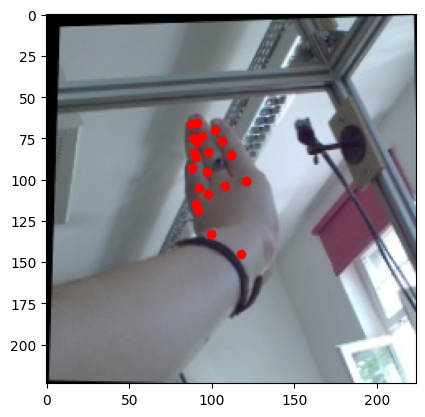

In [26]:
plot_points(img_array, mediapipe_st_kps)

# 3. Custom Model

In [27]:
class HandTopDownRecognition:
    
    def __init__(self, device = "cuda",checkpoint = 'weights/model.bin'):
        self.mano = MANO().to(device)
        self.mano.layer = self.mano.layer.cuda()
        self.mesh_sampler = Mesh()
        self.prepare_augmentation()
        self.create_model(checkpoint, device)
    
    def prepare_augmentation(self):
        self.transform = transforms.Compose([           
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

        self.transform_visualize = transforms.Compose([           
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor()])
    
    def create_model(self, checkpoint, device):
        self._model = torch.load(checkpoint)
        setattr(self._model.trans_encoder[-1].config,'output_attentions', True)
        setattr(self._model.trans_encoder[-1].config,'output_hidden_states', True)
        self._model.trans_encoder[-1].bert.encoder.output_attentions = True
        self._model.trans_encoder[-1].bert.encoder.output_hidden_states =  True
        for iter_layer in range(4):
            self._model.trans_encoder[-1].bert.encoder.layer[iter_layer].attention.self.output_attentions = True
        for inter_block in range(3):
            setattr(self._model.trans_encoder[-1].config,'device', device)
        self._model.to(device)
        
    def run_inference(self, img):
        self._model.eval()
        self.mano.eval()
        with torch.no_grad():
            img_tensor = self.transform(img)
            img_visual = self.transform_visualize(img)
            batch_imgs = torch.unsqueeze(img_tensor, 0).cuda()
            batch_visual_imgs = torch.unsqueeze(img_visual, 0).cuda()
            pred_camera, pred_3d_joints, pred_vertices_sub, pred_vertices, hidden_states, att = self._model(batch_imgs, self.mano, self.mesh_sampler) 
        return pred_3d_joints, pred_camera
    
    def orthographic_projection(self,X, camera):
        camera = camera.view(-1, 1, 3)
        X_trans = X[:, :, :2] + camera[:, :, 1:]
        shape = X_trans.shape
        X_2d = (camera[:, :, 0] * X_trans.view(shape[0], -1)).view(shape)
        return X_2d
    
    def get_keypoints(self, img):
        points_3d, camera = self.run_inference(img)
        points_2d = self.orthographic_projection(points_3d.contiguous(), camera.contiguous())
        return points_2d
    
    
class MediapipeHandDetector:
    def __init__(self):
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(
            static_image_mode=True,
            max_num_hands=1
        )
    
    def make_square(self, box):
        const = 3.078343710504076
        box = box
        cf = int(np.linalg.norm(np.array(box[2:])-np.array(box[:2])) / const)
        x_dist = box[3] - box[1]
        y_dist = box[2] - box[0]
        if x_dist >  y_dist:
            razn = x_dist - y_dist
            box[2] += razn
        elif y_dist >  x_dist:
            razn = y_dist - x_dist
            box[3] += razn
        box[0], box[1], box[2], box[3] =  box[0] - cf, box[1] - cf, box[2] + cf, box[3] + cf
        return box

    def convert_to_bbox(self, box):
        box = np.array(box)
        x_min = np.min(box[:,0]) - 40
        x_max = np.max(box[:,0]) + 40
        y_min = np.min(box[:,1]) - 40
        y_max = np.max(box[:,1]) + 40
        return [x_min,y_min,x_max,y_max]

    def __call__(self, img):
        h, w, _ = img.shape
        results = self.hands.process(img)
        prebox = []
        if results.multi_hand_landmarks is not None:
            for hand_landmarks in results.multi_hand_landmarks:
                hand = []
                for finger_tip in hand_landmarks.landmark:
                    hand.append([int(finger_tip.x * w), int(finger_tip.y * h)])
                prebox.append(self.make_square(self.convert_to_bbox(hand)))
        return prebox
    
    
class CustomModel:
    def __init__(self, hand_detector, keypoints_detector):
        self.hand_detector = hand_detector
        self.keypoints_detector = keypoints_detector
        
    def _get_keypoints(self, img: np.array, points) -> np.array:
        pil_img = Image.fromarray(img)
        pil_img_size = pil_img.size
        crop = pil_img.crop(points)
        keypoints = hand.get_keypoints(crop)
        keypoints = (keypoints + 1) * 0.5
        keypoints[:,:,0] = (keypoints[:,:,0] * crop.size[0]) + points[0]
        keypoints[:,:,1] = (keypoints[:,:,1] * crop.size[1]) + points[1]
        keypoints = keypoints.cpu().detach().squeeze().numpy().astype(int)
        return keypoints
        
    def __call__(self, img: np.array):
        boxes = detector(img)
        if len(boxes):
            return self._get_keypoints(img, boxes[0])
        else:
            return np.array([[0, 0]] * 21)

In [28]:
detector = MediapipeHandDetector()
hand = HandTopDownRecognition()

custom_model = CustomModel(detector, hand)

/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/hom

In [29]:
custom_st_kps = custom_model(img_array)
custom_st_kps.shape

(21, 2)

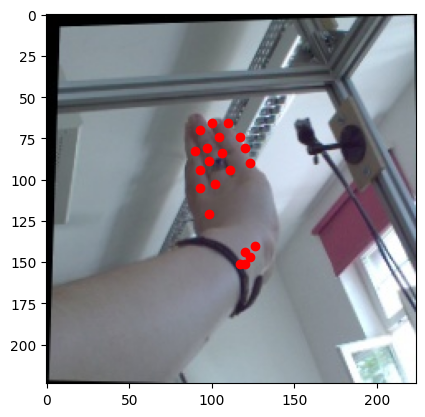

In [31]:
plot_points(img_array, custom_st_kps)

# 4. Metrics

MediaPipe Model:

In [17]:
oks_over_dataset(test_ds, mediapipe_model)

  0%|          | 0/3960 [00:00<?, ?it/s]

0.34132056385087006

Custom model:

In [20]:
oks_over_dataset(test_ds, custom_model)

  0%|          | 0/3960 [00:00<?, ?it/s]

0.26308618649583193

Results:

|Model|OKS|
|:----|:--|
|Mediapipe Hand Key Points Detector|0.341|
|Self Made Detector|0.263|